In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, fminbound
from scipy import stats
from scipy import stats as st
from tableanalyser import discretize_df_columns

In [2]:
working_dir = "/Users/filippo/Developer/tesi"
os.chdir(working_dir)

In [3]:
normalisation_str = "counts"

In [4]:
df = pd.read_csv(("%s/mainTable.csv"%working_dir), index_col=[0])
#df = df.to_sparse(fill_value=0.)
df.head()

,TCGA-3X-AAVE-01A-11R-A41I-07,TCGA-ZD-A8I3-01A-11R-A41I-07,TCGA-ZU-A8S4-01A-11R-A41I-07,TCGA-W6-AA0S-01A-11R-A41I-07,TCGA-3X-AAVB-01A-31R-A41I-07,TCGA-W5-AA38-01A-11R-A41I-07,TCGA-W5-AA31-01A-11R-A41I-07,TCGA-3X-AAV9-01A-72R-A41I-07,TCGA-W5-AA2Z-01A-11R-A41I-07,TCGA-W5-AA2Q-01A-11R-A41I-07,...,GTEX-S32W-1126-SM-4AD5V,GTEX-U4B1-1226-SM-4DXT7,GTEX-S4UY-0926-SM-4AD6O,GTEX-TMMY-1526-SM-4DXST,GTEX-S4Q7-0926-SM-4AD5D,GTEX-U3ZN-1226-SM-4DXUD,GTEX-SNOS-0526-SM-4DM54,GTEX-U3ZM-0826-SM-4DXU6,GTEX-SNMC-0826-SM-4DM66,GTEX-SE5C-1026-SM-4BRUG
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
ENSG00000114771,78.89,265.87,420.68,3.56,186.40,2.27,587.13,71.50,2935.74,450.94,...,15.45,98.73,50.27,0.88,48.52,5.82,112.77,5.45,1015.93,0.59
ENSG00000198691,18.97,111.99,7.57,1.36,5.45,10.63,38.67,85.82,6.41,20.11,...,8.71,20.56,0.13,47.17,14.24,89.51,7.94,43.32,0.06,4.62
ENSG00000073734,1.31,0.87,2.68,2.14,3.29,0.00,51.71,2.78,2.56,4.58,...,4.78,0.00,1.45,1.14,1.10,0.31,2.94,0.03,5.15,0.00
ENSG00000023839,376.41,567.10,17.00,11.55,2.05,693.58,199.85,15.91,64.80,14.78,...,25.54,9.13,21.32,32.82,8.25,7.82,10.16,0.35,6.52,7.94
ENSG00000118777,16.15,15.45,15.11,7.94,20.86,6.78,61.68,51.71,27.25,9.20,...,31.45,18.97,84.63,30.34,37.59,221.86,149.12,43.02,299.25,8.06


In [7]:
df.loc[:,df.columns[np.random.randint(0,5398,size=1000)]].to_csv("mainTable.csv", index=True, header=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16678 entries, ENSG00000121410 to ENSG00000257950
Columns: 5398 entries, TCGA-3X-AAVE-01A-11R-A41I-07 to GTEX-SE5C-1026-SM-4BRUG
dtypes: float64(5398)
memory usage: 687.0+ MB


In [22]:
ngenes = len(df.index)
nfiles = len(df.columns)
print("genes:%d\trealizations:%d"%(ngenes,nfiles))

genes:16678	realizations:5398


## Means sigmas

In [9]:
df_mv = pd.read_csv("meanVariances.csv", index_col = [0])
#type_of_gene='protein-coding'
#df_mv = df_mv.loc[df_mv['type_of_gene']==type_of_gene]
#df_mv_occ=pd.read_csv("O.dat", header=None)
#df_mv.drop("type_of_gene", axis=1, inplace=True)
#df_mv.insert(3, 'occurrence', df_mv_occ.values)
#df_mv.insert(2,'type_of_gene','protein-coding')
df_mv.head()

,mean,variance,type_of_gene,occurrence
ENSG00000121410,428.5660,393606.0,,0.999815
ENSG00000175899,10183.9000,367382000.0,,1.000000
ENSG00000196136,6302.8200,289781000.0,,0.996295
ENSG00000114771,92.5224,127121.0,,0.812523
ENSG00000127837,2357.0700,404279.0,,1.000000


In [10]:
#df_mv.round(2).to_csv("meanVariances.csv",index=True,header=True)
#df_mv.fillna(value=0.,inplace=True)

In [11]:
means = df_mv['mean'].values
variances = df_mv['variance'].values
occurrences = np.array(df_mv['occurrence'].values, dtype=float)
len(df_mv)

16678

### plot

#### **var** versus **mean**

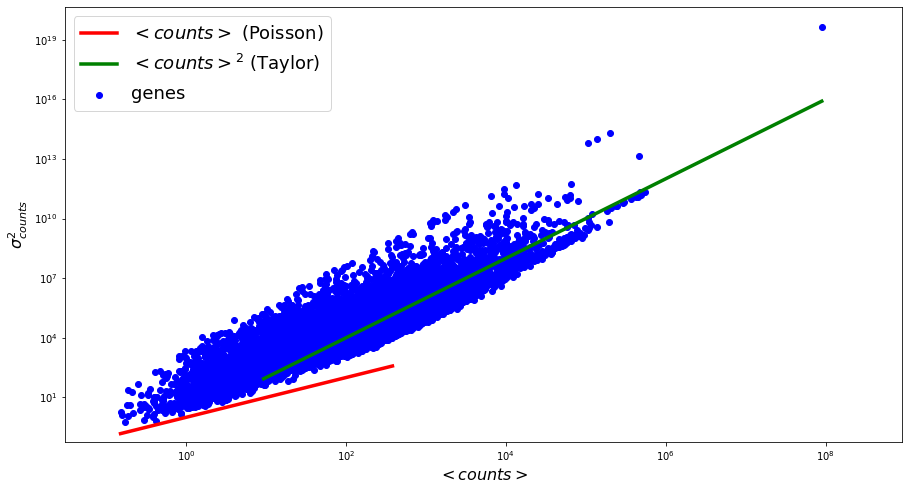

In [12]:
x_lin = np.logspace(np.log10(means[means.nonzero()].min()),np.log10(means[means.nonzero()].max()), dtype=float,num=50)
fig=plt.figure(figsize=(15,8))
plt.scatter(means, variances, c='b', label='genes')
plt.plot(x_lin[:20],x_lin[:20], 'r-', lw=3.5, label='$<%s>$ (Poisson)'%normalisation_str)
plt.plot(x_lin[-40:],np.power(x_lin[-40:],2), 'g-', lw=3.5, label='$<%s>^2$ (Taylor)'%normalisation_str)

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim((variances[variances.nonzero()].min()/10,np.power(10,np.log10(variances.max())+1)))
plt.legend(fontsize=18)
plt.show()
fig.savefig("varmean_loglog.png")

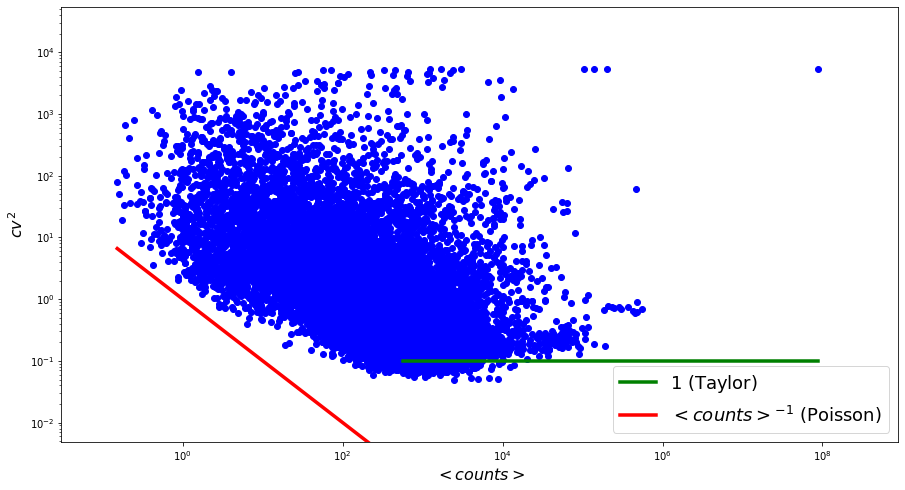

In [13]:
cv2 = np.array([variances[i]/(np.power(mean,2)) for i,mean in enumerate(means) if mean>0])
fig=plt.figure(figsize=(15,8))
plt.scatter(means[means.nonzero()], cv2, c='b')
plt.plot(x_lin[-30:],[1e-1 for _ in x_lin[-30:]], 'g-', lw=3.5, label='$1$ (Taylor)')
plt.plot(x_lin[:30],1./x_lin[:30], 'r-', lw=3.5, label='$<%s>^{-1}$ (Poisson)'%normalisation_str)

#plt.plot(x_lin, [nfiles-1 for _ in x_lin], color='cyan', ls='--', lw=3.5, label='bound')

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$cv^2$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim((cv2[cv2.nonzero()].min()/10,np.power(10,np.log10(cv2.max())+1)))
plt.legend(fontsize=18)
plt.show()
fig.savefig("cvmean_loglog.png")

# overexpressed

In [14]:
how_many_sigmas = 2
distance = 10

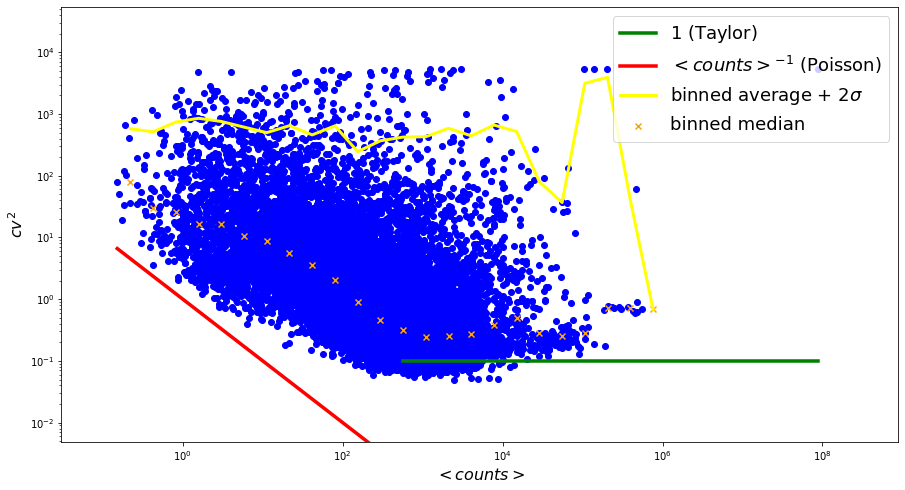

In [15]:
cv2 = np.array([variances[i]/(np.power(mean,2)) for i,mean in enumerate(means) if mean>0])
fig=plt.figure(figsize=(15,8))
plt.scatter(means[means.nonzero()], cv2, c='b')

plt.plot(x_lin[-30:],[1e-1 for _ in x_lin[-30:]], 'g-', lw=3.5, label='$1$ (Taylor)')
plt.plot(x_lin[:30],1./x_lin[:30], 'r-', lw=3.5, label='$<%s>^{-1}$ (Poisson)'%normalisation_str)

#plt.plot(x_lin, [nfiles-1 for _ in x_lin], color='cyan', ls='--', lw=3.5, label='bound')

log_bins_for_x = np.logspace(np.log10(means[means.nonzero()].min()),6,25)

bin_means, bin_edges, _ = st.binned_statistic(means[means.nonzero()], cv2, statistic='median', bins=log_bins_for_x)
plt.scatter((bin_edges[:-1]+bin_edges[1:])/2.,bin_means, marker='x', color='orange', label='binned median')

bin_sigmas,  _, _ = stats.binned_statistic(means[means.nonzero()], cv2, statistic=np.std, bins=log_bins_for_x)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_means+bin_sigmas*how_many_sigmas, lw=3, color='yellow', label='binned average + $%d\sigma$'%how_many_sigmas)


plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$cv^2$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim((cv2[cv2.nonzero()].min()/10,np.power(10,np.log10(cv2.max())+1)))
plt.legend(fontsize=18)
plt.show()
fig.savefig("cvmean_loglog_%dsigma.png"%how_many_sigmas)

In [16]:
def get_mean_cv2(mean, cv2, knee=1., distance=distance):
    if mean < knee:
        return(mean, cv2, -1, -1, cv2 > distance+1./mean)
    else:
        return(mean, cv2, -1, -1, cv2 > 1e-1+distance)

In [32]:
def get_mean_cv2(mean, cv2, how_many_sigmas=3):
    bin_i = 0
    for i in range(len(bin_edges[:-1])):
        if mean<=bin_edges[i+1] and mean > bin_edges[i]:
            bin_i = i
            break
    return(mean, cv2, bin_means[bin_i], bin_sigmas[bin_i], cv2>(bin_means[bin_i]+how_many_sigmas*bin_sigmas[bin_i]))

In [22]:
over = []
for g in df_mv.index:
    subdf = df_mv.loc[g,:]
    mean = float(subdf['mean'])
    var = subdf['variance']
    if mean> 1e5 or mean< 1e-3:
        continue
    r = get_mean_cv2(mean,float(var)/mean/mean, knee=100)
    if r[4]:
        over.append(g)

In [23]:
len(over)

2477

In [24]:
over_plot = []
for g in over:
    subdf = df_mv.loc[g,]
    mean = subdf['mean']
    var = subdf['variance']
    occ = subdf['occurrence']
    cv2 = float(var)/mean/mean
    over_plot.append([mean,cv2,occ])
over_plot=np.array(over_plot)

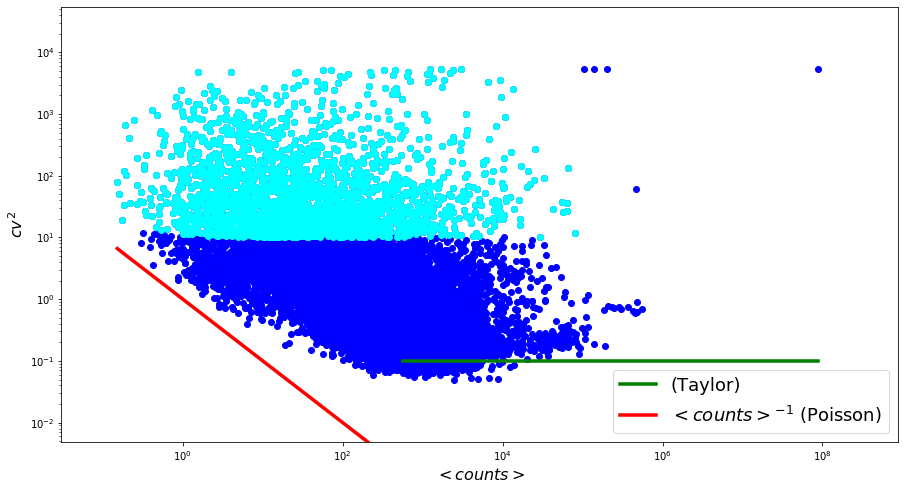

In [25]:
cv2 = np.array([variances[i]/(np.power(mean,2)) for i,mean in enumerate(means) if mean>0])
fig=plt.figure(figsize=(15,8))
plt.scatter(means[means.nonzero()], cv2, c='b')
plt.scatter(over_plot.T[0],over_plot.T[1], color='cyan')

plt.plot(x_lin[-30:],[1e-1 for _ in x_lin[-30:]], 'g-', lw=3.5, label='(Taylor)')
plt.plot(x_lin[:30],1./x_lin[:30], 'r-', lw=3.5, label='$<%s>^{-1}$ (Poisson)'%normalisation_str)
#plt.plot(x_lin, [nfiles-1 for _ in x_lin], color='cyan', ls='--', lw=3.5, label='bound')

log_bins_for_x = np.logspace(np.log10(means[means.nonzero()].min()),5,25)

#bin_means, bin_edges, _ = st.binned_statistic(means[means.nonzero()], cv2, statistic='median', bins=log_bins_for_x)
#plt.scatter((bin_edges[:-1]+bin_edges[1:])/2.,bin_means, marker='x', color='orange', label='binned median')

#bin_sigmas,  _, _ = stats.binned_statistic(means[means.nonzero()], cv2, statistic=np.std, bins=log_bins_for_x)
#plt.hlines(bin_means+bin_sigmas*how_many_sigmas,bin_edges[1:], bin_edges[:-1], lw=3, color='yellow', label='binned average + $%d\sigma$'%how_many_sigmas)


plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$cv^2$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim((cv2[cv2.nonzero()].min()/10,np.power(10,np.log10(cv2.max())+1)))
plt.legend(fontsize=18)
plt.show()
fig.savefig("cvmean_loglog_over%d.png"%how_many_sigmas)

In [26]:
#discretize_df_columns(df.loc[over, df.columns[np.unique(np.random.randint(len(df.columns), size=2000))]]).to_csv("main_Table_Altmann.csv",index=True, header=True)

In [28]:
df.loc[over,:].dropna().to_csv("mainTable_over.csv",index=True, header=True)

### mean versus occurrence

In [ ]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences*nfiles, means, c='b', alpha=0.8, label='genes')
if 'counts' in normalisation_str:
    plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles), lw=4, label='bound', c='cyan', ls='--')
bin_means, bin_edges, _ = stats.binned_statistic(occurrences*nfiles, means, statistic='mean', bins=np.logspace(-3,6))
x = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(x,bin_means, marker='x', c='r', label='binned average')
plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.legend(fontsize=16)
plt.show()
fig.savefig("meanDiff_loglog.png")

In [ ]:
fig=plt.figure(figsize=(8,5))
plt.scatter(means, occurrences*nfiles, c='b', alpha=0.6, label='data')
bin_means, bin_edges, _ = stats.binned_statistic(means, occurrences*nfiles, statistic='mean', bins=np.logspace(-3,6))
x = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(x,bin_means, marker='x', c='r', label='binned average')
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.ylabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim(5e-1,nfiles+800)
plt.legend(fontsize=16)
plt.show()
fig.savefig("diffMean_loglog.png")

### Distributions

In [ ]:
fig = plt.figure()
data = means
mu = np.median(data)
s = np.std(data)
log_bins = np.logspace(-5,7)
plt.hist(data, density = False, histtype='step', bins=log_bins)
plt.title("means", fontsize=16)
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("#", fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-5,5e5)
plt.show()
fig.savefig("mean_distr.pdf")

In [ ]:
fig = plt.figure(figsize=(7,7))
data = -np.log10(means[means.nonzero()])
minimum = data.min()
data -= minimum
mu = np.median(data)
s = np.std(data)
fit_params = st.lognorm.fit(data)
n, c, _ = plt.hist(data, density = True, histtype='step')
plt.plot(np.linspace(-1,10),st.lognorm.pdf(np.linspace(-1,10),*fit_params), label='lognormal (s:%.2f,loc:%.2f,scale:%.2f)'%(fit_params))
plt.title("means", fontsize=16)
plt.xlabel("$-log10(<%s>)+%.2f$"%(normalisation_str,-minimum), fontsize=16)
plt.ylabel("pdf", fontsize=16)
plt.yscale('log')
plt.ylim(1e-4,1)
plt.xlim(-1,10)
plt.legend(fontsize=16)
plt.show()
fig.savefig("mean_distr_scaled.pdf")

In [ ]:
bins = 80
bins=np.logspace(np.log10(5e-1),np.log10(variances.max()))
fig = plt.figure()
n, c, _ = plt.hist(variances, density = False, histtype='step', bins=bins)

plt.title("vars", fontsize=16)
plt.xlabel("$<\sigma_{%s}^2>$"%normalisation_str, fontsize=16)
plt.ylabel("#", fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.show()
fig.savefig("var_distr.pdf")

In [ ]:
fig = plt.figure(figsize=(7,7))
data = -np.log10(variances[variances.nonzero()])
minimum = data.min()
data -= minimum
mu = np.median(data)
s = np.std(data)
fit_params = st.lognorm.fit(data)
n, c, _ = plt.hist(data, density = True, histtype='step')
plt.plot(np.linspace(-1,data.max()),st.lognorm.pdf(np.linspace(-1,data.max()),*fit_params), label='lognormal (s:%.2f,loc:%.2f,scale:%.2f)'%(fit_params))
plt.title("means", fontsize=16)
plt.xlabel("$-log10(<%s>)+%.2f$"%(normalisation_str,-minimum), fontsize=16)
plt.ylabel("pdf", fontsize=16)
plt.yscale('log')
plt.ylim(1e-4,1)
plt.xlim(data.min()-1,data.max()+1)
plt.legend(fontsize=16)
plt.show()
fig.savefig("var_distr_scaled.pdf")

# null

In [ ]:
df_null = pd.read_csv(("%s/nullTable.csv"%working_dir), header=None, index_col=[0])
df_null.head()

## meanVariances

In [ ]:
df_mv_null = pd.read_csv("meanVariances_null.csv", usecols=[1,2])
df_mv_null.head()

In [ ]:
df_occ_null = pd.read_csv("O_null.dat", header=None)
df_mv_null.insert(2,'occurrence', np.array(df_occ_null.values,dtype=float))
#df_mv_null.to_csv("meanVariances_null.csv", index=False, header=True)
df_mv_null.head()

In [ ]:
means_null = np.round(df_mv_null['mean'].values,1)
variances_null = np.round(df_mv_null['variance'].values,1)
occurrences_null = np.round(np.array(df_mv_null['occurrence'].values, dtype=float)*nfiles,1)
len(df_mv_null)

In [ ]:
x = means
y = variances
x_lin = np.logspace(np.log10(x[x.nonzero()].min()),np.log10(x[x.nonzero()].max()), dtype=float,num=50)

In [ ]:
high_means = df_mv[df_mv['occurrence']==1]['mean'].values
high_var = df_mv[df_mv['occurrence']==1]['variance'].values

In [ ]:
fig=plt.figure(figsize=(12,7))

plt.scatter(x, y, label = 'genes', marker='o', alpha=0.8, linewidths=0.1)

#plt.scatter(high_means, high_var, label = '$O_i=1$', marker='o',c='cyan', alpha=0.4, lw=0.1)

log_bins_for_x = np.logspace(-5, np.log10(np.max(x)), num=50)
bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.scatter((bin_edges[:-1]+bin_edges[1:])/2., bin_means, color='r', marker='x', lw=2, label='binned average')

plt.plot(x_lin[-40:],np.power(x_lin[-40:],2), 'g-', lw=3.5, label='$<%s>^2$ (Taylor)'%normalisation_str)
plt.plot(x_lin[:20],x_lin[:20], 'r-', lw=3.5, label='$<%s>$ (Poisson)'%normalisation_str)


#popt, pcov = curve_fit(lambda x,a,b : a*np.power(x,b), bin_centres, bin_means, bounds=([1,1],[35,5]))
#plt.plot(bin_centres, popt[0]*np.power(bin_centres, popt[1]), color='y', lw=3, label='fit')
#print(popt[0],popt[1])

bin_sigmas,  bin_sigmas_edges, binsigmanumber = stats.binned_statistic(x, y, statistic=np.std, bins=log_bins_for_x)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_means+bin_sigmas*3, lw=3, color='yellow', label='binned average + $3\sigma$')

plt.scatter(means_null, variances_null, label='sampling')

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.legend(fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(x[x.nonzero()].min()/100,np.power(10,np.log10(x.max())+1))
plt.ylim((y[y.nonzero()].min()/100,np.power(10,np.log10(y.max())+1)))
plt.show()
fig.savefig("varmean_3sigma.png")

In [ ]:
cv2 = np.array([variances[i]/(np.power(mean,2)) for i,mean in enumerate(means) if mean>0])
cv2_null = [variances_null[i]/(np.power(mean,2)) for i,mean in enumerate(means_null) if mean>0]
fig=plt.figure(figsize=(15,8))
plt.scatter(means[means.nonzero()], cv2, c='b', label ='genes')
plt.scatter(means_null[means_null.nonzero()], cv2_null, c='orange', label='sampling')
plt.plot(x_lin[:30],1./x_lin[:30], 'r-', lw=3.5, label='Poisson')
plt.plot(x_lin[20:],[1e-1 for _ in x_lin[20:]], 'g-', lw=3.5, label='Taylor')
plt.plot(x_lin,[nfiles-1 for _ in x_lin], color='cyan', lw=3, ls='--', label='bound')

bin_means, bin_edges, binnumber = stats.binned_statistic(means[means.nonzero()], cv2, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.scatter((bin_edges[:-1]+bin_edges[1:])/2., bin_means, color='r', marker='x', lw=2, label='binned average')

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$cv^2$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim((cv2[cv2.nonzero()].min()/10,np.power(10,np.log10(cv2.max())+1)))
plt.legend(fontsize=16)
plt.show()
fig.savefig("cvmean_loglog_sampling.png")

In [ ]:
x = means
y = variances

# INIT FIGURE #################################################################

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()


# AX #########################################################################

xmin = np.log10(1e-3)
xmax = np.log10(x.max())
ymin = np.log10(1e-6)
ymax = np.log10(y.max())

nbins=80

xbins = np.logspace(xmin, xmax, nbins) # <- make a range from 10**xmin to 10**xmax
ybins = np.logspace(ymin, ymax, nbins) # <- make a range from 10**ymin to 10**ymax
counts, _, _, _ = ax.hist2d(x, y, bins=(xbins, ybins));

pcm = ax.pcolormesh(xbins, ybins, counts.T)
plt.colorbar(pcm)
#fig.colorbar(pcm, ax=ax)  # this works too


ax.set_xscale("log")               # <- Activate log scale on X axis
ax.set_yscale("log")               # <- Activate log scale on Y axis

ax.set_xlim(xmin=xbins[0])
ax.set_xlim(xmax=xbins[-1])
ax.set_ylim(ymin=ybins[0])
ax.set_ylim(ymax=ybins[-1])

ax.set_title("")
ax.set_xlabel("$<%s>$"%normalisation_str, fontsize=16)
ax.set_ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)

# SHOW AND SAVE FILE ##########################################################

plt.tight_layout()
plt.show()
fig.savefig("varmean_density.png")

In [ ]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences*nfiles, means, c='b', alpha=0.6, label='genes')

log_bins_for_x = np.logspace(-5, np.log10(np.max(x)), num=50)
bin_means, bin_edges, binnumber = stats.binned_statistic(occurrences*nfiles, means, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5, label='binned average')

plt.scatter(occurrences_null, means_null, c='orange', alpha=0.6, label='sampling')

plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles), lw=3, label='$\\frac{O_i}{Nsamples}$', c='cyan', ls='--')
plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.legend(fontsize=16, loc='upper left')
plt.show()
fig.savefig("meanDiff_binned_sampling.png")

In [ ]:
x = occurrences
y = means

# INIT FIGURE #################################################################

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()


# AX #########################################################################

xmin = np.log10(9e-1)
xmax = np.log10(x.max())
ymin = np.log10(5e-4)
ymax = np.log10(y.max())

nbins=80

xbins = np.logspace(xmin, xmax, nbins) # <- make a range from 10**xmin to 10**xmax
ybins = np.logspace(ymin, ymax, nbins) # <- make a range from 10**ymin to 10**ymax
counts, _, _, _ = ax.hist2d(x, y, bins=(xbins, ybins));

pcm = ax.pcolormesh(xbins, ybins, counts.T)
plt.colorbar(pcm)
#fig.colorbar(pcm, ax=ax)  # this works too


ax.set_xscale("log")               # <- Activate log scale on X axis
ax.set_yscale("log")               # <- Activate log scale on Y axis

ax.set_xlim(xmin=xbins[0])
ax.set_xlim(xmax=xbins[-1])
ax.set_ylim(ymin=ybins[0])
ax.set_ylim(ymax=ybins[-1])

ax.set_title("")
ax.set_ylabel("$<%s>$"%normalisation_str, fontsize=16)
ax.set_xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)

# SHOW AND SAVE FILE ##########################################################

plt.tight_layout()
plt.show()
fig.savefig("meanDiff_density.png")

## Lenght

In [ ]:
q_many = pd.read_csv("genes.txt", index_col=[0], header=[0])
q_many = q_many[q_many['type_of_gene']=='protein-coding']
lenghts = q_many['lenght']
df_mv.insert(3,'lenght',lenghts)
df_mv.head()

In [ ]:
from scipy.stats import binned_statistic
fig=plt.figure(figsize=(15,7))
lenghts = df_mv['lenght'].values
means = df_mv['mean'].values
bin_means, bin_edges, _ = binned_statistic(lenghts, means, statistic='mean', bins=np.logspace(1,7))
plt.scatter(lenghts,means)
plt.scatter((bin_edges[1:]+bin_edges[:-1])/2., bin_means, marker='x')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('lenght (bp)', fontsize=16)
plt.ylabel('mean (counts)', fontsize=16)
plt.xlim((lenghts.min()/10,lenghts.max()*10))
plt.ylim((means[means.nonzero()].min()/10,means.max()*10))
plt.show()
fig.savefig("meanLenght.pdf")

In [ ]:
df_mv=pd.read_csv("results/counts/meanVariances.csv", index_col=[0])
df_mv.head()

In [ ]:
df_mv_fpkm=pd.read_csv("results/proteincoding/meanVariances.csv", index_col=[0])
df_mv_fpkm.head()

In [ ]:
df_mv_rpk=pd.read_csv("results/rpk/meanVariances.csv", index_col=[0])
df_mv_rpk.head()

In [ ]:
diffnormmeans = []
for g in df_mv.index:
    try:
        diffnormmeans.append([g,df_mv.at[g,'lenght'],df_mv.at[g,'mean'],df_mv_fpkm.at[g,'mean'], df_mv_rpk.at[g,'mean']])
    except:
        print("skipping %s"%g)

In [ ]:
fig=plt.figure(figsize=(24,8))
ax=fig.subplots(1,3)
dataset = np.array(diffnormmeans).T
lenghts = np.array(dataset[1],dtype=float)
means = np.array(dataset[2],dtype=float)
bin_means, bin_edges, _ = binned_statistic(lenghts, means, statistic='mean', bins=np.logspace(1,7))
ax[0].scatter(lenghts,means, label='genes')
ax[0].scatter((bin_edges[1:]+bin_edges[:-1])/2., bin_means, marker='x', label='binned average')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('lenght (bp)', fontsize=16)
ax[0].set_ylabel('mean (counts)', fontsize=16)
ax[0].set_xlim((lenghts.min()/5,lenghts.max()*5))
ax[0].set_ylim((means[means.nonzero()].min()/10,means.max()*10))
means = np.array(dataset[3],dtype=float)
bin_means, bin_edges, _ = binned_statistic(lenghts, means, statistic='mean', bins=np.logspace(1,7))
ax[1].scatter(lenghts,means, label='genes')
ax[1].scatter((bin_edges[1:]+bin_edges[:-1])/2., bin_means, marker='x',label='binned average')
ax[1].plot(lenghts,np.power(lenghts,-0.5)*1e3, label='$L[kilobp]^{-0.5}$', lw=2, color='red')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('lenght (bp)', fontsize=16)
ax[1].set_ylabel('mean (FPKM)', fontsize=16)
ax[1].set_xlim((lenghts.min()/5,lenghts.max()*5))
ax[1].set_ylim((means[means.nonzero()].min()/10,means.max()*10))
ax[1].legend(fontsize=16)
means = np.array(dataset[4],dtype=float)
bin_means, bin_edges, _ = binned_statistic(lenghts, means, statistic='mean', bins=np.logspace(1,7))
ax[2].scatter(lenghts,means, label='genes')
ax[2].plot(lenghts,np.power(lenghts,-1)*1e6, label='$L[kilobp]^{-1}$', lw=2, color='red')
ax[2].scatter((bin_edges[1:]+bin_edges[:-1])/2., bin_means, marker='x',label='binned average')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_xlabel('lenght (bp)', fontsize=16)
ax[2].set_ylabel('mean (RPK)', fontsize=16)
ax[2].set_xlim((lenghts.min()/5,lenghts.max()*5))
ax[2].set_ylim((means[means.nonzero()].min()/10,means.max()*10))
ax[2].legend(fontsize=16)
plt.show()
fig.savefig("meanLenght_fpkm_rpk.pdf")

# P_i

In [ ]:
#query_g = df_mv[df_mv['mean']>1e-4].index.values
query_g = df_mv.index.values

In [ ]:
len(query_g)

In [ ]:
N = df.loc[query_g,:].sum(axis=0)

In [ ]:
df_null.index=df.index
N_null = df_null.loc[query_g,:].sum(axis=0)

In [ ]:
df_p = df.loc[query_g,:].div(N.values, axis=1)

In [ ]:
df_p_null = df_null.loc[query_g,:].div(N_null.values, axis=1)

In [ ]:
means = df_p.apply(np.average, axis=1).values
variances = df_p.apply(np.var, axis=1).values
o = df_p.apply(lambda x: float(len(np.nonzero(x)[0]))/len(x),axis=1).values

In [ ]:
means_null = df_p_null.apply(np.average, axis=1).values
variances_null = df_p_null.apply(np.var, axis=1).values
o_null = df_p_null.apply(lambda x: float(len(np.nonzero(x)[0]))/len(x),axis=1).values

In [ ]:
x = means
y = variances
log_bins_for_x = np.logspace(np.log10(x[x.nonzero()].min()),np.log10(x[x.nonzero()].max()), dtype=float,num=30)

In [ ]:
x_null = means_null
y_null = variances_null
log_bins_for_x_null = np.logspace(np.log10(x_null[x_null.nonzero()].min()),np.log10(x_null[x_null.nonzero()].max()), dtype=float,num=30)

In [ ]:
x_high = df_p.loc[df_mv[df_mv['occurrence']==1].index,:].mean(axis=1).values
y_high = df_p.loc[df_mv[df_mv['occurrence']==1].index,:].var(axis=1).values

In [ ]:
fig=plt.figure(figsize=(12,7))

plt.scatter(x, y, label = 'genes', marker='o', alpha=0.8, linewidths=0.1)
plt.scatter(x_high, y_high, label = '$O_i=1$', marker='o', alpha=0.4, color='cyan', linewidths=0.1)
#plt.scatter(x_null, y_null, label = 'sampling', marker='o', alpha=0.8, linewidths=0.1)

bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5, label='binned average')

plt.plot(log_bins_for_x[-40:],np.power(log_bins_for_x[-40:],2), 'g-', lw=3.5, label='$<p_i>^2$ (Taylor)')
plt.plot(log_bins_for_x[:],log_bins_for_x[:], 'r-', lw=3.5, label='$<p_i>$ (Poisson)')
plt.plot(log_bins_for_x[:],log_bins_for_x[:]*1e-8, ls='-', color='darkred', lw=3.5, label='$10^{-8}*<p_i>$ (Poisson)')



plt.xlabel("$<p_i>$", fontsize=16)
plt.ylabel("$\sigma^2_{p_i}$", fontsize=16)
plt.legend(fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(x[x.nonzero()].min()/100,np.power(10,np.log10(x.max())+1))
plt.ylim((y[y.nonzero()].min()/100,np.power(10,np.log10(y.max())+1)))
plt.show()
fig.savefig("pi_varmean_3sigma.png")

In [ ]:
fig = plt.figure()
data = means
mu = np.median(data)
s = np.std(data)
log_bins = np.logspace(-12,-2)
plt.hist(data, density = False, histtype='step', bins=log_bins)
plt.title("means", fontsize=16)
plt.xlabel("$<pi>$", fontsize=16)
plt.ylabel("#", fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.xlim(data[data.nonzero()].min(),data.max())
plt.show()
fig.savefig("pi_mean_distr.pdf")

## over mean

In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
o_min = 3e1
o_max = nfiles
m_min = 5e4
m_max = 1e6

In [ ]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences, means, c='b', alpha=0.6, label='data')
plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles*10), lw=2, label='', c='r')

width = o_max - o_min
height = m_max-m_min
plt.gca().add_patch(Rectangle((o_min,m_min), width=width, height=height, fill=False))

plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.show()
plt.savefig("highmean.png")

In [ ]:
up = []
for g in df_mv.index:
    subdf = df_mv.loc[g,:]
    mean = subdf['mean']
    occ = subdf['occurrence']
    if mean>m_min and mean < m_max and occ*nfiles > o_min and occ*nfiles< o_max:
        up.append(g)

In [ ]:
len(up)

In [ ]:
for g in up:
    print(g)

In [ ]:
dat = df.loc['ENSG00000042832'].values
np.var(dat)/(np.average(dat)**2)

In [ ]:
df_mv[df_mv['mean']>0].sort_values(by='variance', axis=0, ascending=False)

## set by occurrence

In [ ]:
with open("o1.txt",'a') as f:
    for g in df_mv[df_mv['occurrence']>4990].index:
        f.write("%s\n"%g)

## data size Heaps check

In [ ]:
col = df.loc[:,df.keys()[1]].values
np.sum(col)

In [ ]:
len(col[col.nonzero()])

In [ ]:
x = []
y = []
for i in range(1, nfiles):
    col = df.loc[:,df.keys()[i]].values
    x.append(np.sum(col))
    y.append(len(col.nonzero()[0]))
plt.scatter(x,y)

In [ ]:
i=794
x=[]
y=[]
col = df.loc[:,df.keys()[i]].values
x.append(np.sum(col))
y.append(len(col.nonzero()[0]))

In [ ]:
x

In [ ]:
y

In [ ]:
col[8142:8150]

## Imagesave

In [ ]:
bits = np.array([df.loc[g,:].values for g in df.index])

In [ ]:
from PIL import Image
img = Image.fromarray(bits, mode='1')
img.save("mat.bmp")